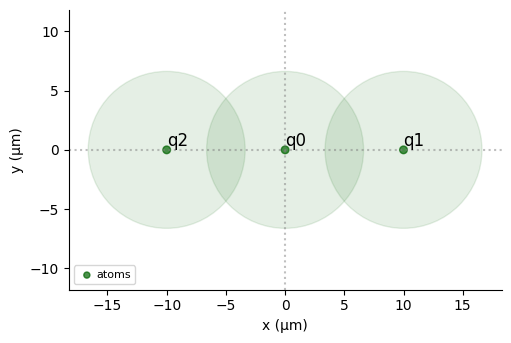

In [105]:
from pulser import Sequence, Pulse, Register
from pulser.waveforms import ConstantWaveform, BlackmanWaveform
from pulser.devices import MockDevice  # or Chadoq2 if you want physical constraints
import pulser
import numpy as np

# One-qubit register
coords = [(0, 0), (10, 0), (-10, 0)]
reg = Register.from_coordinates(coords, prefix="q")

# Create sequence
seq = Sequence(reg,pulser.DigitalAnalogDevice)
seq.declare_channel("ch1", "rydberg_global")

def hadamard(glob_seq):
    pulse = BlackmanWaveform(252,np.pi/2)
    pi_2_pulse = Pulse.ConstantDetuning(pulse, detuning=0, phase=0) # y-axis rotation
    pulse2 = BlackmanWaveform(500,np.pi)
    pi_pulse = Pulse.ConstantDetuning(pulse2, detuning=0, phase=0) # x-axis rotation
    glob_seq.add(pi_2_pulse, "ch1")
    glob_seq.add(pi_pulse, "ch1") 


# Define a register with one qubit
reg.draw(
    blockade_radius=pulser.DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True)
zerowave = ConstantWaveform(100, 10.0) # zero detuning
hadamard(seq)


In [106]:
from pulser_simulation import QutipEmulator

simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
psi_final = results.get_final_state()
psi_final

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[-0.03236189-0.25590778j]
 [-0.02382292-0.14267335j]
 [-0.02382292-0.14267335j]
 [ 0.06429971-0.19166033j]
 [ 0.0557044 -0.1740194j ]
 [-0.48034095+0.18711581j]
 [-0.48034095+0.18711581j]
 [ 0.53468123+0.j        ]]

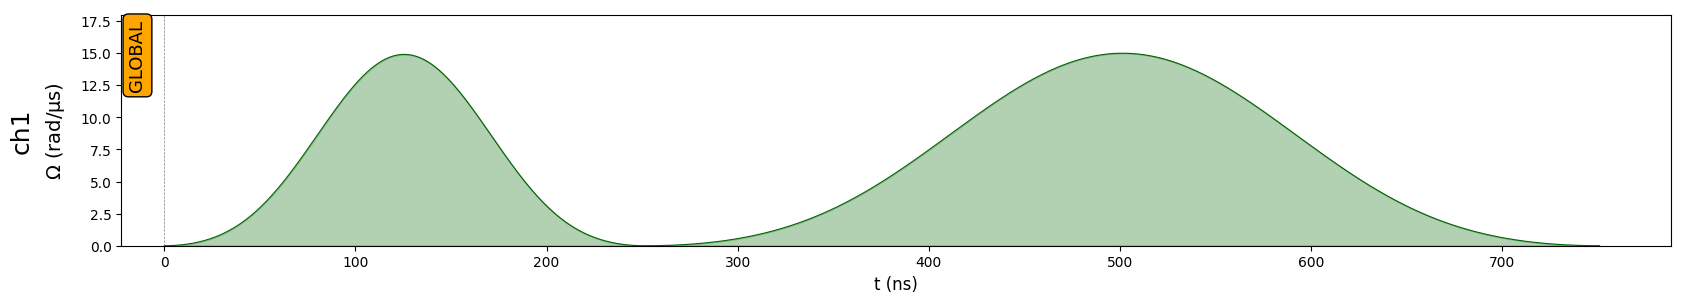

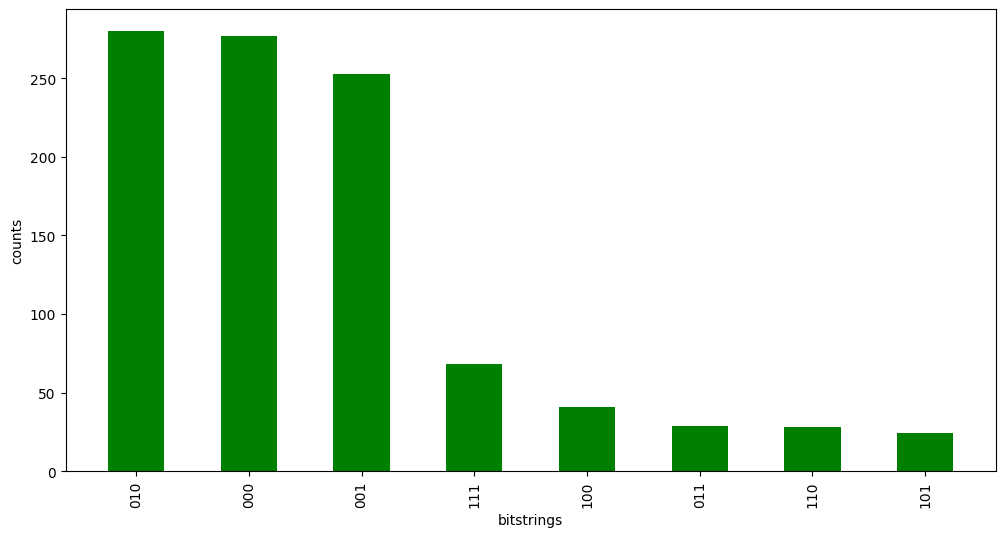

Counter({'010': 280, '000': 277, '001': 253, '111': 68, '100': 41, '011': 29, '110': 28, '101': 24})


In [107]:
import matplotlib.pyplot as plt

def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

seq.draw()
plot_distribution(count_dict)
print(count_dict)

In [108]:
s_readable = seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="Sequence_with_defaults",
)
with open("hadamard_u.json", "w") as f:
    f.write(s_readable)

In [ ]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [4]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

In [5]:
coords

array([[ 5.43591935,  1.83221016],
       [ 5.30433156, -6.2289737 ],
       [-1.57590666, -2.14702291],
       [ 1.61714433, 11.07433973],
       [15.37762057,  2.91043984]])

In [6]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    print(t)
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

NameError: name 'reg' is not defined

In [ ]:
t_list[0]

VariableItem(var=Variable(name='t_list', dtype=<class 'float'>, size=2), key=0)

In [ ]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [ ]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
muharray=[]
for i in range(2 ** len(Q)):
    print(f'i:{i} binary repr:{np.binary_repr(i, len(Q))}')
    muharray.append(np.binary_repr(i, len(Q)))

i:0 binary repr:00000
i:1 binary repr:00001
i:2 binary repr:00010
i:3 binary repr:00011
i:4 binary repr:00100
i:5 binary repr:00101
i:6 binary repr:00110
i:7 binary repr:00111
i:8 binary repr:01000
i:9 binary repr:01001
i:10 binary repr:01010
i:11 binary repr:01011
i:12 binary repr:01100
i:13 binary repr:01101
i:14 binary repr:01110
i:15 binary repr:01111
i:16 binary repr:10000
i:17 binary repr:10001
i:18 binary repr:10010
i:19 binary repr:10011
i:20 binary repr:10100
i:21 binary repr:10101
i:22 binary repr:10110
i:23 binary repr:10111
i:24 binary repr:11000
i:25 binary repr:11001
i:26 binary repr:11010
i:27 binary repr:11011
i:28 binary repr:11100
i:29 binary repr:11101
i:30 binary repr:11110
i:31 binary repr:11111


In [ ]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
list('00000')
for binarystring in bitstrings:
    z = np.array(list(binarystring), dtype=int) # is a list of integer representing the current binary string
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [ ]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    print(Q)
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.3

In [ ]:
coords

array([[ 5.43591935,  1.83221016],
       [ 5.30433156, -6.2289737 ],
       [-1.57590666, -2.14702291],
       [ 1.61714433, 11.07433973],
       [15.37762057,  2.91043984]])

In [7]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
qubits

{'q0': array([5.43591935, 1.83221016]),
 'q1': array([ 5.30433156, -6.2289737 ]),
 'q2': array([-1.57590666, -2.14702291]),
 'q3': array([ 1.61714433, 11.07433973]),
 'q4': array([15.37762057,  2.91043984])}

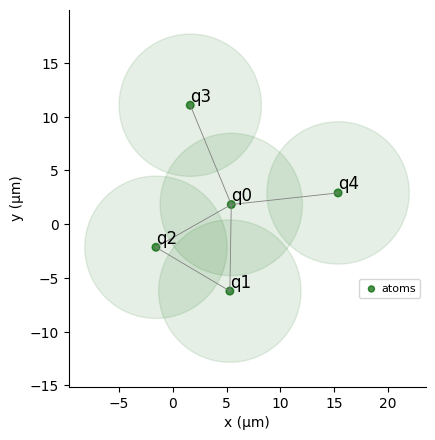

In [8]:
qubits = {'q0': np.array([5.43591935, 1.83221016]),
 'q1': np.array([ 5.30433156, -6.2289737 ]),
 'q2': np.array([-1.57590666, -2.14702291]),
 'q3': np.array([ 1.61714433, 11.07433973]),
 'q4': np.array([15.37762057,  2.91043984])}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [9]:
LAYERS = 4

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)


for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [ ]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [11]:
np.random.seed(151)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

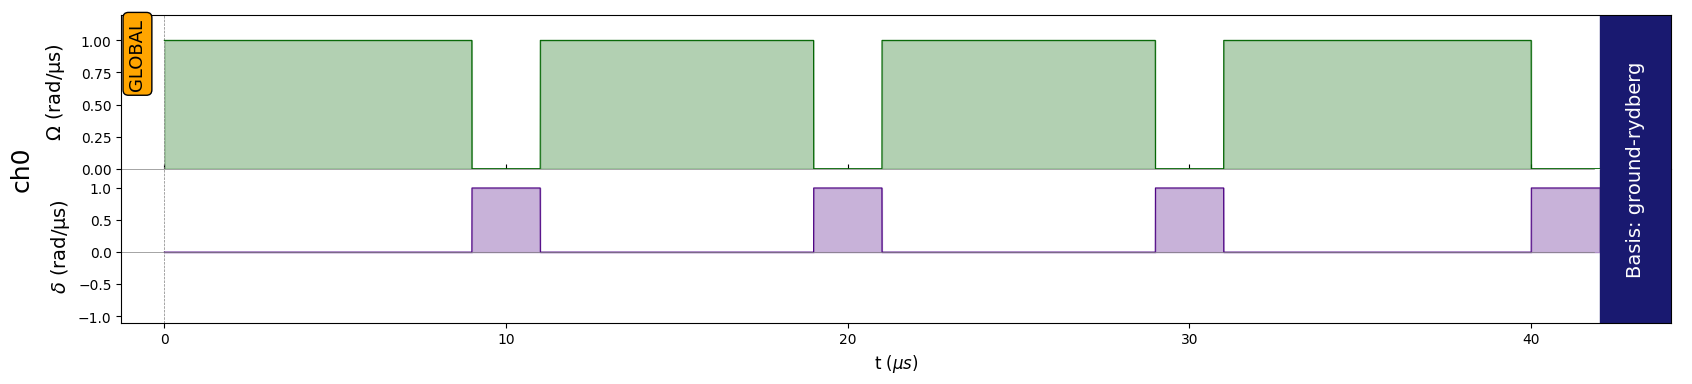

Counter({'00011': 227,
         '00001': 174,
         '00010': 158,
         '01000': 61,
         '00100': 59,
         '00000': 56,
         '00111': 46,
         '01011': 44,
         '01010': 41,
         '00110': 34,
         '01001': 33,
         '00101': 33,
         '10010': 9,
         '01100': 7,
         '10001': 7,
         '01111': 4,
         '10000': 3,
         '01110': 2,
         '01101': 1,
         '11001': 1})

In [12]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])
example_dict


In [13]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

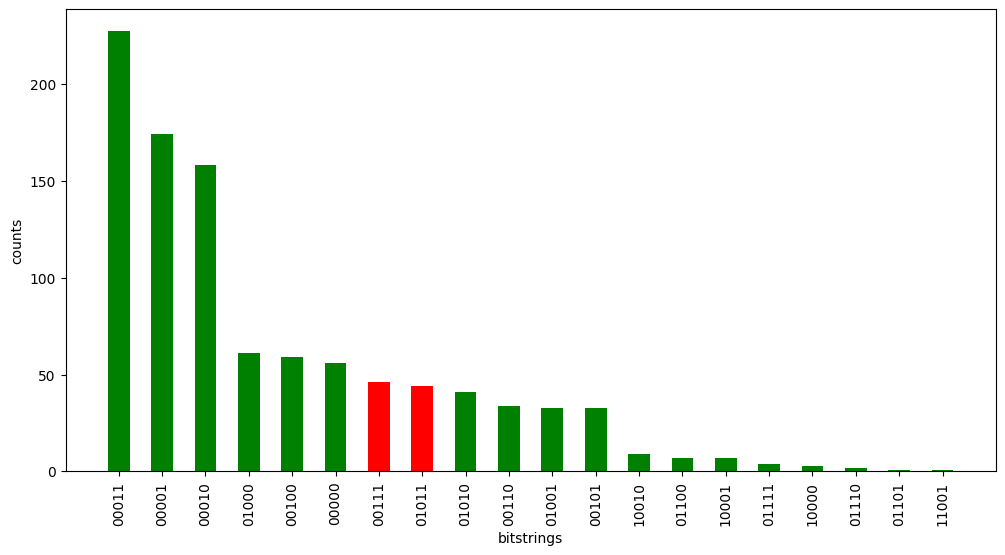

In [14]:
plot_distribution(example_dict)